In [158]:
# from __future__ import division
import itertools
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from datetime import datetime as dt
from matplotlib import style
from os.path import exists
from random import randint
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from wrangle_zillow import wrangle_zillow

warnings.filterwarnings("ignore")

In [75]:
from env import host, user, password

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [76]:
url = get_db_url("grocery_db")

sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [77]:
# Cluster on all or a selected subset of features
grocery_milk_fresh = df[["Grocery", "Milk", "Fresh"]]
grocery_milk_fresh.head(2)

,Grocery,Milk,Fresh
customer_id,,,
0,7561,9656,12669
1,9568,9810,7057


In [78]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(grocery_milk_fresh)

# Use the scaler
grocery_milk_fresh = scaler.transform(grocery_milk_fresh)
grocery_milk_fresh

array([[0.08146416, 0.13072723, 0.11294004],
       [0.10309667, 0.13282409, 0.06289903],
       [0.08278992, 0.11918086, 0.05662161],
       ...,
       [0.32594285, 0.21013575, 0.1295431 ],
       [0.02402535, 0.02622442, 0.091727  ],
       [0.02702178, 0.02237109, 0.02482434]])

In [79]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(grocery_milk_fresh)

DBSCAN(eps=0.1, min_samples=20)

In [80]:
# Now, let's add the scaled value columns back onto the dataframe
columns = ["Grocery", "Milk", "Fresh"]
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(grocery_milk_fresh, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Milk,Scaled_Fresh
0,2,3,12669,9656,7561,214,2674,1338,0.081464,0.130727,0.112940
1,2,3,7057,9810,9568,1762,3293,1776,0.103097,0.132824,0.062899
2,2,3,6353,8808,7684,2405,3516,7844,0.082790,0.119181,0.056622
3,1,3,13265,1196,4221,6404,507,1788,0.045464,0.015536,0.118254
4,2,3,22615,5410,7198,3915,1777,5185,0.077552,0.072914,0.201626


In [81]:
# Assign the cluster labels
# Recall that cluster labels don't have inherent meaning
# DBSCAN makes a cluster called -1 that contains the "noise" or outliers
df['labels'] = dbsc.labels_
df.labels.value_counts()

 0    409
-1     31
Name: labels, dtype: int64

In [82]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Milk,Scaled_Fresh,labels
0,2,3,12669,9656,7561,214,2674,1338,0.081464,0.130727,0.112940,0
1,2,3,7057,9810,9568,1762,3293,1776,0.103097,0.132824,0.062899,0
2,2,3,6353,8808,7684,2405,3516,7844,0.082790,0.119181,0.056622,0
3,1,3,13265,1196,4221,6404,507,1788,0.045464,0.015536,0.118254,0
4,2,3,22615,5410,7198,3915,1777,5185,0.077552,0.072914,0.201626,0


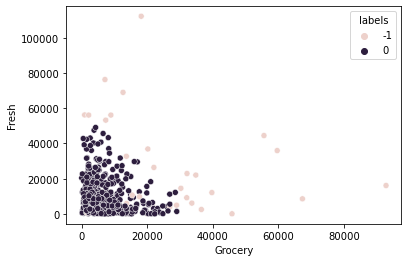

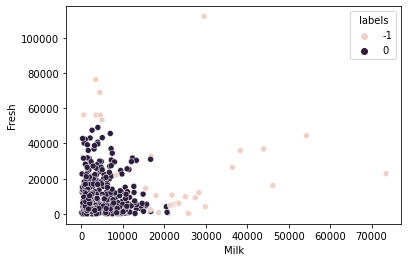

In [83]:
sns.scatterplot(df.Grocery, df.Fresh, hue=df.labels)
plt.show()

sns.scatterplot(df.Milk, df.Fresh, hue=df.labels)
plt.show()

# Exercise
* Clustering - DBSCAN

# Use DBSCAN to detect anomalies in other products from the customers dataset. The database name is grocery_db.


In [84]:
#get subset of features for scaling and scanning
columns = ["Frozen", "Detergents_Paper", "Delicassen"]
frozen_det_deli = df[columns]

In [85]:
# Make the scaler
scaler = MinMaxScaler()

# Fit the scaler
scaler.fit(frozen_det_deli)

# Use the scaler
frozen_det_deli = scaler.transform(frozen_det_deli)


In [86]:
# Make the object
dbsc = DBSCAN(eps = .10, min_samples = 20)

# Fit the object
dbsc.fit(frozen_det_deli)

DBSCAN(eps=0.1, min_samples=20)

In [87]:
# Now, let's add the scaled value columns back onto the dataframe
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(frozen_det_deli, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Milk,Scaled_Fresh,labels,Scaled_Frozen,Scaled_Detergents_Paper,Scaled_Delicassen
0,2,3,12669,9656,7561,214,2674,1338,0.081464,0.130727,0.112940,0,0.003106,0.065427,0.027847
1,2,3,7057,9810,9568,1762,3293,1776,0.103097,0.132824,0.062899,0,0.028548,0.080590,0.036984
2,2,3,6353,8808,7684,2405,3516,7844,0.082790,0.119181,0.056622,0,0.039116,0.086052,0.163559
3,1,3,13265,1196,4221,6404,507,1788,0.045464,0.015536,0.118254,0,0.104842,0.012346,0.037234
4,2,3,22615,5410,7198,3915,1777,5185,0.077552,0.072914,0.201626,0,0.063934,0.043455,0.108093


In [88]:
# Assign the cluster labels
# Recall that cluster labels don't have inherent meaning
# DBSCAN makes a cluster called -1 that contains the "noise" or outliers
df['labels_b'] = dbsc.labels_
df.labels.value_counts()

 0    409
-1     31
Name: labels, dtype: int64

In [89]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Grocery,Scaled_Milk,Scaled_Fresh,labels,Scaled_Frozen,Scaled_Detergents_Paper,Scaled_Delicassen,labels_b
0,2,3,12669,9656,7561,214,2674,1338,0.081464,0.130727,0.112940,0,0.003106,0.065427,0.027847,0
1,2,3,7057,9810,9568,1762,3293,1776,0.103097,0.132824,0.062899,0,0.028548,0.080590,0.036984,0
2,2,3,6353,8808,7684,2405,3516,7844,0.082790,0.119181,0.056622,0,0.039116,0.086052,0.163559,0
3,1,3,13265,1196,4221,6404,507,1788,0.045464,0.015536,0.118254,0,0.104842,0.012346,0.037234,0
4,2,3,22615,5410,7198,3915,1777,5185,0.077552,0.072914,0.201626,0,0.063934,0.043455,0.108093,0


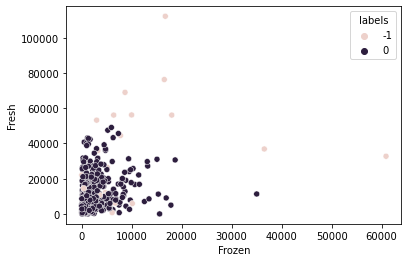

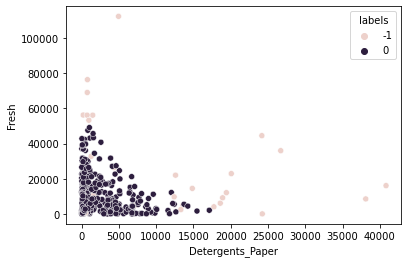

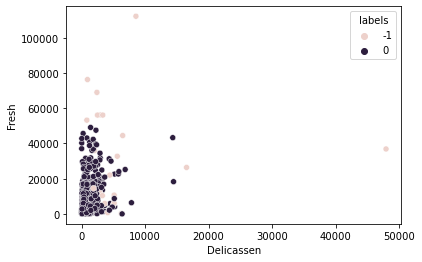

In [90]:
sns.scatterplot(df.Frozen, df.Fresh, hue=df.labels)
plt.show()

sns.scatterplot(df.Detergents_Paper, df.Fresh, hue=df.labels)
plt.show()

sns.scatterplot(df.Delicassen, df.Fresh, hue=df.labels)
plt.show()

# Use DBSCAN to detect anomalies in requests from the curriculum access logs in the curriculum_logs database.


In [91]:
#need to import logs
log_url = get_db_url('curriculum_logs')

log_sql = """ 
select * 
from logs
join cohorts 
on logs.cohort_id = cohorts.id
"""
if exists('curriculum_logs'):
    df_b = pd.read_csv('curriculum_logs')
else:
    df_b = pd.read_sql(log_sql, log_url, index_col='date')
    df_b.to_csv('curriculum_logs')

In [92]:
df.index = pd.to_datetime(df.index)

In [93]:
df_b = df_b.drop(columns=['cohort_id', 'id', 'slack', 'created_at', 'updated_at', 'deleted_at'])

In [94]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847330 entries, 0 to 847329
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        847330 non-null  object
 1   time        847330 non-null  object
 2   path        847329 non-null  object
 3   user_id     847330 non-null  int64 
 4   ip          847330 non-null  object
 5   name        847330 non-null  object
 6   start_date  847330 non-null  object
 7   end_date    847330 non-null  object
 8   program_id  847330 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 58.2+ MB


What would be considered a weird about requests?
* Alot of requests from same user at different ip addresses. Although they may be using vpn.
* Requests outside cohort or student end date in large numbers

In [143]:
df_b.time = pd.to_datetime(df_b.time, format='%H:%M:%S').dt.strftime('%H')

In [151]:
#staring with ip
id_counts = df_b.groupby(['user_id'])['ip','path'].nunique()

In [153]:
id_counts.sort_values(['path','ip'], ascending=False).head(20)

,ip,path
user_id,,
1,35,976
11,32,871
248,11,625
64,34,436
581,5,354
404,7,352
485,8,349
53,15,333
480,5,297


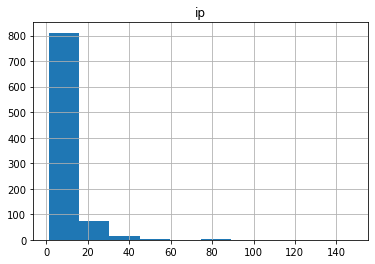

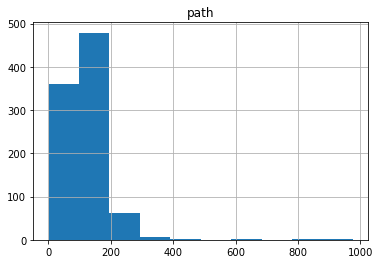

In [154]:
for col in id_counts:
    id_counts[col].hist()
    plt.title(col)
    plt.show()

## Takeaways
* outliers in each column

In [155]:
def clusterize(df, min_samples=20, eps=0.1):
    """ 
    Purpose

    ---
    Parameters

    ---
    Returns

    """

    scaler = MinMaxScaler().fit(df)
    scaled_df = scaler.transform(df)
    scaled_cols = [col + '_scaled' for col in df.columns]
    scaled_df = pd.DataFrame(scaled_df, columns=scaled_cols, index=df.index)

    #construc dbscan object
    dbsc = DBSCAN(min_samples=20, eps=0.1)
    dbsc.fit(scaled_df)
    print(dbsc.labels_.shape)
    print(scaled_df.shape)

    df_total = df.merge(
        scaled_df, on=df.index).drop(
        columns=['key_0'])

    df_total['labels'] = dbsc.labels_
    df_total[df_total.labels == -1]
    df = df_total

    print("Population")
    print(df.describe())
    print("-------------")
    print("Inliers")
    print(df[df.labels==0].describe())
    print("-------------")
    print("Outliers")
    print(df[df.labels==-1].describe())
    plt.scatter(df.iloc[:, 0],
            df.iloc[:, 1],
            c=df['labels'])
    plt.title(f'Cluster assignment by {df.columns[0]} and {df.columns[1]} counts per user')
    plt.xlabel(f'{df.columns[0]} counts')
    plt.ylabel(f'{df.columns[1]} counts')
    plt.show()


    return df


(911,)
(911, 2)
Population
               ip        path   ip_scaled  path_scaled      labels
count  911.000000  911.000000  911.000000   911.000000  911.000000
mean     7.755214  118.299671    0.045954     0.120307   -0.015368
std     11.677367   80.402266    0.079438     0.082464    0.123078
min      1.000000    1.000000    0.000000     0.000000   -1.000000
25%      2.000000   53.500000    0.006803     0.053846    0.000000
50%      5.000000  140.000000    0.027211     0.142564    0.000000
75%      9.000000  165.000000    0.054422     0.168205    0.000000
max    148.000000  976.000000    1.000000     1.000000    0.000000
-------------
Inliers
               ip        path   ip_scaled  path_scaled  labels
count  897.000000  897.000000  897.000000   897.000000   897.0
mean     6.743590  114.943144    0.039072     0.116865     0.0
std      7.180783   68.143609    0.048849     0.069891     0.0
min      1.000000    1.000000    0.000000     0.000000     0.0
25%      2.000000   53.000000    

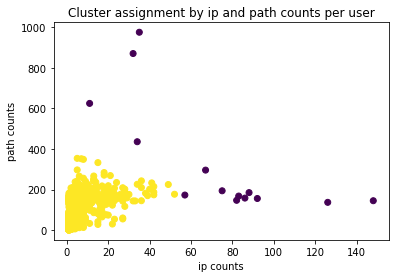

,ip,path,ip_scaled,path_scaled,labels
0,35,976,0.231293,1.000000,-1
1,12,151,0.074830,0.153846,0
2,25,169,0.163265,0.172308,0
3,11,143,0.068027,0.145641,0
4,4,197,0.020408,0.201026,0
...,...,...,...,...,...
906,6,12,0.034014,0.011282,0
907,4,18,0.020408,0.017436,0
908,7,20,0.040816,0.019487,0
909,1,1,0.000000,0.000000,0


In [156]:
clusterize(id_counts)

In [157]:

# Scale each attribute linearly. 
# # create the scaler
# scaler = MinMaxScaler().fit(page_views)
# # use the scaler
# scaled_page_views = scaler.transform(page_views)

# scaled_page_views[0:5]
# # whip up some new column names
# scaled_cols = [col + '_scaled' for col in page_views.columns]
# scaled_cols
# scaled_page_views_df = pd.DataFrame(scaled_page_views, columns=scaled_cols, index=page_views.index)
# Construct a DBSCAN object that requires a minimum of 20 data points in a neighborhood of radius 0.1 to be considered a core point.
# # create the object first
# dbsc = DBSCAN(min_samples=20, eps=0.1)
# dbsc
# # fit the object like we normally would with sklearn
# dbsc.fit(scaled_page_views_df)
# dbsc.labels_.shape
# scaled_page_views_df.shape
# page_views.head(2)
# scaled_page_views_df.head(2)
# # Merge the scaled and non-scaled values into one dataframe
# page_views_total = page_views.merge(
#     scaled_page_views_df, on=page_views.index).drop(
#     columns=['key_0'])
# # sanity check for the shape of the df:
# page_views_total.shape
# # let's apply the dbscan labels
# page_views_total['labels'] = dbsc.labels_
# page_views_total[page_views_total.labels == -1]
# page_views = page_views_total
# # Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
# print("Population")
# print(page_views.describe())
# print("-------------")
# print("Inliers")
# print(page_views[page_views.labels==0].describe())
# print("-------------")
# print("Outliers")
# print(page_views[page_views.labels==-1].describe())
# plt.scatter(page_views['count'],
#            page_views['nunique'],
#            c=page_views['labels'])
# plt.title('Cluster assignment by page count and unique count per user')
# plt.show()

SyntaxError: invalid syntax (4252343177.py, line 1)

# Use DBSCAN to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [159]:
#import the data
df, train, validate, test, train_scaled, validate_scaled, test_scaled = wrangle_zillow()


(28971, 22) (12417, 22) (10348, 22)


In [161]:
#create dataframe that features only the columns we want to look at
rooms_and_area = df[['area', 'bedrooms']]

(51736,)
(51736, 2)
Population
               area      bedrooms   area_scaled  bedrooms_scaled        labels
count  51736.000000  51736.000000  51736.000000     51736.000000  51736.000000
mean    1918.913349      3.307098      0.081137         0.300645     -0.000290
std      994.228663      0.931425      0.045655         0.084675      0.017025
min      152.000000      0.000000      0.000000         0.000000     -1.000000
25%     1268.000000      3.000000      0.051247         0.272727      0.000000
50%     1657.000000      3.000000      0.069110         0.272727      0.000000
75%     2301.000000      4.000000      0.098682         0.363636      0.000000
max    21929.000000     11.000000      1.000000         1.000000      0.000000
-------------
Inliers
               area      bedrooms   area_scaled  bedrooms_scaled   labels
count  51721.000000  51721.000000  51721.000000     51721.000000  51721.0
mean    1916.018484      3.305872      0.081004         0.300534      0.0
std      975.8

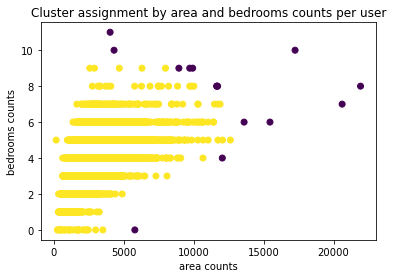

,area,bedrooms,area_scaled,bedrooms_scaled,labels
0,3100.0,4.0,0.135372,0.363636,0
1,1465.0,2.0,0.060293,0.181818,0
2,1243.0,3.0,0.050099,0.272727,0
3,2376.0,4.0,0.102126,0.363636,0
4,2962.0,4.0,0.129035,0.363636,0
...,...,...,...,...,...
51731,1633.0,4.0,0.068008,0.363636,0
51732,1286.0,2.0,0.052073,0.181818,0
51733,1612.0,4.0,0.067043,0.363636,0
51734,1032.0,3.0,0.040410,0.272727,0


In [162]:
#clusterize
clusterize(rooms_and_area)